In [71]:
!pip install sentinelsat rasterio geopandas matplotlib

In [72]:
import zipfile, os, glob

In [73]:
zip_path = "Browser_images_2.zip"
extract_dir = "sentinel_data"

In [74]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [75]:
import os

# List all files in the extract directory (including subfolders)
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))


sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B02_(Raw).tiff
sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B03_(Raw).tiff
sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B04_(Raw).tiff
sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B08_(Raw).tiff
sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_Agriculture.tiff


In [76]:
# Finding required bands ---
red_file   = glob.glob(os.path.join(extract_dir, "*B04*.tiff"))[0]  # Red
nir_file   = glob.glob(os.path.join(extract_dir, "*B08*.tiff"))[0]  # NIR
green_file = glob.glob(os.path.join(extract_dir, "*B03*.tiff"))[0]  # Green
blue_file  = glob.glob(os.path.join(extract_dir, "*B02*.tiff"))[0]  # Blue

print("Red:", red_file)
print("NIR:", nir_file)
print("Green:", green_file)
print("Blue:", blue_file)


Red: sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B04_(Raw).tiff
NIR: sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B08_(Raw).tiff
Green: sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B03_(Raw).tiff
Blue: sentinel_data/2025-04-03-00:00_2025-04-03-23:59_Sentinel-2_L2A_B02_(Raw).tiff


In [77]:
# Loading Bands
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open(red_file) as r, \
     rasterio.open(nir_file) as n, \
     rasterio.open(blue_file) as b, \
     rasterio.open(green_file) as g:
        red = r.read(1).astype("float32")
        nir = n.read(1).astype("float32")
        blue = b.read(1).astype("float32")
        green = g.read(1).astype("float32")
        profile = r.profile


/tmp/ipykernel_128/100075721.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir+red)==0, 0, (nir-red)/(nir+red))
/tmp/ipykernel_128/100075721.py:12: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((green+nir)==0, 0, (green-nir)/(green+nir))


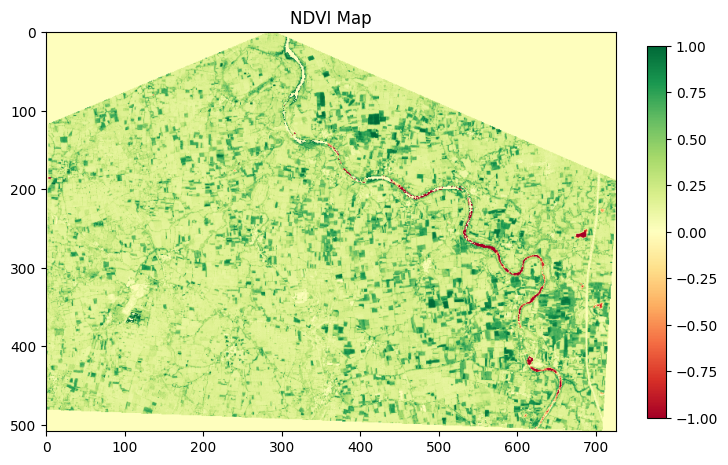

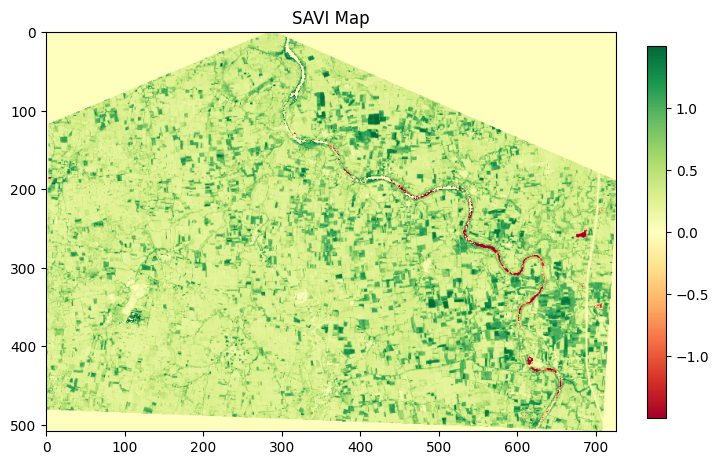

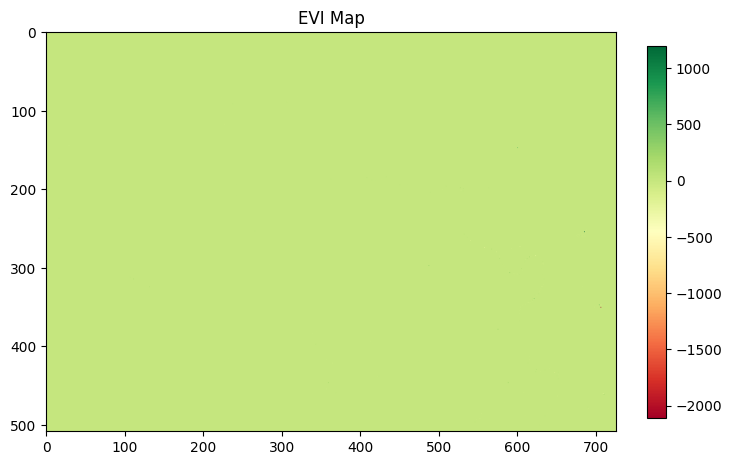

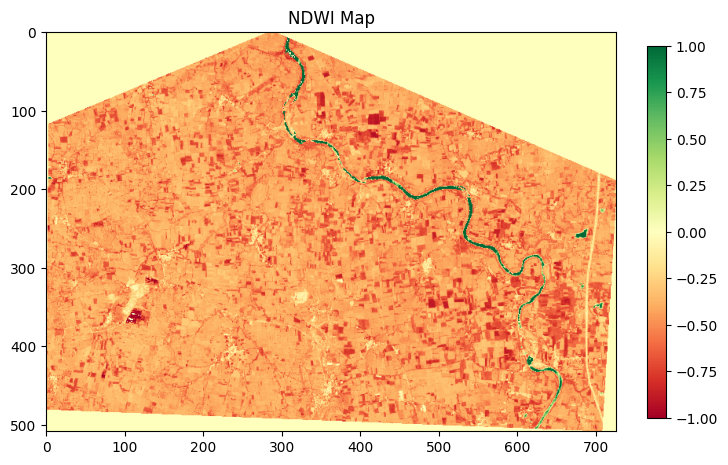

In [78]:
# NDVI = (NIR - Red) / (NIR + Red)
ndvi = np.where((nir+red)==0, 0, (nir-red)/(nir+red))

# SAVI = (1.5 * (NIR - Red)) / (NIR + Red + 0.5)
savi = np.where((nir+red+0.5)==0, 0, (1.5*(nir-red))/(nir+red+0.5))

# EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
evi = np.where((nir + 6*red - 7.5*blue + 1)==0, 0,
               2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1))

# NDWI = (Green - NIR) / (Green + NIR)
ndwi = np.where((green+nir)==0, 0, (green-nir)/(green+nir))

# Plotting results
indices = {"NDVI": ndvi, "SAVI": savi, "EVI": evi, "NDWI": ndwi}

for name, data in indices.items():
    plt.figure(figsize=(8,6))
    plt.imshow(data, cmap='RdYlGn')
    plt.colorbar(fraction=0.03)
    plt.title(f"{name} Map")
    plt.show()

In [79]:
# Saving all indices as GeoTIFF
for name, data in indices.items():
    profile.update(dtype=rasterio.float32, count=1)
    out_path = f"{name}.tif"
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(data, 1)
    print(f"{name} saved as {out_path}")

NDVI saved as NDVI.tif
SAVI saved as SAVI.tif
EVI saved as EVI.tif
NDWI saved as NDWI.tif
